### Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from utils.custom_loss import CustomLoss
from utils.utils import get_preprocessor, get_tensors, run_experiment, plot_loss, load_saved_model

sns.set_style('darkgrid')

2022-12-19 21:37:21.723160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Read in the data

In [3]:
df = pd.read_csv('house-prices-data/train.csv', index_col=0)
target_col = 'SalePrice'
y = df[target_col]

cols_to_drop = ['Utilities', target_col]
df.drop(cols_to_drop, inplace=True, axis=1)

print('shape:', df.shape)
df.head()

shape: (1460, 78)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Split into train and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=101)

### Instantiate the column transformer and transform the training data

In [5]:
# The processing here is just converting to numerical values. 
# Predictions can be made better by feature engineering.
col_transformer = get_preprocessor('yeo-johnson')

X_train = col_transformer.fit_transform(X_train)
X_train = X_train
n_rows, n_cols = X_train.shape
features = [f'col_{i}' for i in range(n_cols)]
X_train = pd.DataFrame(X_train, columns=features)
print('shape:', X_train.shape)

y_train_scaler = StandardScaler()
y_train = y_train_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
X_train[target_col] = y_train

shape: (1314, 260)


### Transform test data
To avoid leakage, the col_transformer fit on the training data is used to transform the test data as well. 

In [6]:
X_test = col_transformer.transform(X_test)
X_test = X_test
n_rows, n_cols = X_test.shape
X_test = pd.DataFrame(X_test, columns=features)
print('shape:', X_test.shape)

y_test_scaler = StandardScaler()
y_test = y_test_scaler.fit_transform(y_test.values.reshape(-1, 1)).flatten()
X_test[target_col] = y_test

shape: (146, 260)


### Read in the results from the hyperparameter search

In [7]:
# The search results are written with a timestamp, enter your results file name here.
search_results_file = 'search-results-2022-12-16-15-05-22.csv'
df_results = pd.read_csv(search_results_file, index_col=0)
df_results.sort_values('val_pearson', inplace=True)
df_results.head()

,run_id,val_pearson,val_mse,params
387,run_387_0,-1.000000,380.275909,"{""n_layers"": 2, ""n_units"": 13, ""learning_rate""..."
126,run_126_0,-1.000000,5010.564941,"{""n_layers"": 2, ""n_units"": 169, ""learning_rate..."
111,run_111_0,-1.000000,11734.695312,"{""n_layers"": 1, ""n_units"": 227, ""learning_rate..."
157,run_157_0,-0.933513,0.140324,"{""n_layers"": 1, ""n_units"": 338, ""learning_rate..."
270,run_270_0,-0.932662,0.152127,"{""n_layers"": 2, ""n_units"": 493, ""learning_rate..."


Looking at the first 3 rows, the best correlations are the top 3. However, there is a high correlation with much lower mse at index 157 and 270.

In [8]:
best_params = json.loads(df_results.loc[270, 'params'])
best_params

{'n_layers': 2,
 'n_units': 493,
 'learning_rate': 0.02096530185407847,
 'activation': 'sigmoid',
 'dropout': 0.11336407649504665,
 'batchsize': 210}

### Create the TensorFlow train and test datasets

In [9]:
batchsize = best_params['batchsize']
train_dataset = get_tensors(X_train, features, target_col, batchsize=batchsize)
test_dataset = get_tensors(X_test, features, target_col, batchsize=batchsize)

2022-12-19 21:37:28.231698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Using the CustomLoss class and the best params from the search, build the model and run the training

In [10]:
mse_scale = 10000000
pearson_scale = 100000
loss = CustomLoss(mse_scale, pearson_scale)

prob_bnn_model, history = run_experiment(best_params, 
                         features, 
                         loss,
                         2000, 
                         train_dataset, 
                         test_dataset)

Start training the model...
Epoch 1/2000
7/7 [==============================] - 3s 131ms/step - loss: 748749824.0000 - pearson: 0.1279 - mean_squared_error: 76.0542 - val_loss: 119289728.0000 - val_pearson: 0.0452 - val_mean_squared_error: 12.0336
Epoch 2/2000
7/7 [==============================] - 0s 29ms/step - loss: 52540452.0000 - pearson: -0.0330 - mean_squared_error: 5.1680 - val_loss: 20872458.0000 - val_pearson: -0.4314 - val_mean_squared_error: 1.9887
Epoch 3/2000
7/7 [==============================] - 0s 26ms/step - loss: 20266888.0000 - pearson: -0.2351 - mean_squared_error: 1.9338 - val_loss: 10774756.0000 - val_pearson: -0.0919 - val_mean_squared_error: 1.0631
Epoch 4/2000
7/7 [==============================] - 0s 29ms/step - loss: 12647069.0000 - pearson: -0.1491 - mean_squared_error: 1.2126 - val_loss: 11311774.0000 - val_pearson: -0.5111 - val_mean_squared_error: 1.0423
Epoch 5/2000
7/7 [==============================] - 0s 25ms/step - loss: 11274119.0000 - pearson: -0.

Epoch 38/2000
7/7 [==============================] - 0s 23ms/step - loss: 2485250.0000 - pearson: -0.9417 - mean_squared_error: 0.1839 - val_loss: 1871672.1250 - val_pearson: -0.9430 - val_mean_squared_error: 0.1229
Epoch 39/2000
7/7 [==============================] - 0s 22ms/step - loss: 2466997.0000 - pearson: -0.9569 - mean_squared_error: 0.1825 - val_loss: 1963911.2500 - val_pearson: -0.9384 - val_mean_squared_error: 0.1313
Epoch 40/2000
7/7 [==============================] - 0s 22ms/step - loss: 2500292.5000 - pearson: -0.9555 - mean_squared_error: 0.1873 - val_loss: 2058927.7500 - val_pearson: -0.9431 - val_mean_squared_error: 0.1417
Epoch 41/2000
7/7 [==============================] - 0s 23ms/step - loss: 2535925.5000 - pearson: -0.9258 - mean_squared_error: 0.1902 - val_loss: 1950623.7500 - val_pearson: -0.9379 - val_mean_squared_error: 0.1351
Epoch 42/2000
7/7 [==============================] - 0s 22ms/step - loss: 2496478.7500 - pearson: -0.9444 - mean_squared_error: 0.1844 -

Epoch 76/2000
7/7 [==============================] - 0s 23ms/step - loss: 1700606.8750 - pearson: -0.9709 - mean_squared_error: 0.1205 - val_loss: 1962701.6250 - val_pearson: -0.9395 - val_mean_squared_error: 0.1452
Epoch 77/2000
7/7 [==============================] - 0s 26ms/step - loss: 1601302.6250 - pearson: -0.9706 - mean_squared_error: 0.1103 - val_loss: 1525074.0000 - val_pearson: -0.9523 - val_mean_squared_error: 0.1031
Epoch 78/2000
7/7 [==============================] - 0s 23ms/step - loss: 1664192.8750 - pearson: -0.9776 - mean_squared_error: 0.1158 - val_loss: 1531997.7500 - val_pearson: -0.9473 - val_mean_squared_error: 0.1065
Epoch 79/2000
7/7 [==============================] - 0s 23ms/step - loss: 1583193.0000 - pearson: -0.9609 - mean_squared_error: 0.1097 - val_loss: 1881168.0000 - val_pearson: -0.9398 - val_mean_squared_error: 0.1440
Epoch 80/2000
7/7 [==============================] - 0s 23ms/step - loss: 1599108.6250 - pearson: -0.9621 - mean_squared_error: 0.1107 -

Epoch 114/2000
7/7 [==============================] - 0s 22ms/step - loss: 1926582.3750 - pearson: -0.9705 - mean_squared_error: 0.1524 - val_loss: 2494954.0000 - val_pearson: -0.9458 - val_mean_squared_error: 0.2106
Epoch 115/2000
7/7 [==============================] - 0s 23ms/step - loss: 1671576.7500 - pearson: -0.9590 - mean_squared_error: 0.1280 - val_loss: 2157866.5000 - val_pearson: -0.9303 - val_mean_squared_error: 0.1773
Epoch 116/2000
7/7 [==============================] - 0s 23ms/step - loss: 1533734.3750 - pearson: -0.9588 - mean_squared_error: 0.1143 - val_loss: 2592825.5000 - val_pearson: -0.9481 - val_mean_squared_error: 0.2192
Epoch 117/2000
7/7 [==============================] - 0s 24ms/step - loss: 1761492.5000 - pearson: -0.9719 - mean_squared_error: 0.1377 - val_loss: 2226041.5000 - val_pearson: -0.9351 - val_mean_squared_error: 0.1852
Epoch 118/2000
7/7 [==============================] - 0s 23ms/step - loss: 1489188.8750 - pearson: -0.9727 - mean_squared_error: 0.1

Epoch 152/2000
7/7 [==============================] - 0s 24ms/step - loss: 887336.1250 - pearson: -0.9781 - mean_squared_error: 0.0583 - val_loss: 1478000.5000 - val_pearson: -0.9473 - val_mean_squared_error: 0.1142
Epoch 153/2000
7/7 [==============================] - 0s 23ms/step - loss: 816726.3750 - pearson: -0.9847 - mean_squared_error: 0.0495 - val_loss: 1486253.3750 - val_pearson: -0.9474 - val_mean_squared_error: 0.1146
Epoch 154/2000
7/7 [==============================] - 0s 24ms/step - loss: 913258.9375 - pearson: -0.9733 - mean_squared_error: 0.0608 - val_loss: 1611285.1250 - val_pearson: -0.9477 - val_mean_squared_error: 0.1290
Epoch 155/2000
7/7 [==============================] - 0s 24ms/step - loss: 966178.5000 - pearson: -0.9635 - mean_squared_error: 0.0653 - val_loss: 1370395.7500 - val_pearson: -0.9528 - val_mean_squared_error: 0.1059
Epoch 156/2000
7/7 [==============================] - 0s 23ms/step - loss: 1004175.0000 - pearson: -0.9848 - mean_squared_error: 0.0705 

Epoch 190/2000
7/7 [==============================] - 0s 25ms/step - loss: 755282.1875 - pearson: -0.9764 - mean_squared_error: 0.0494 - val_loss: 1379702.3750 - val_pearson: -0.9500 - val_mean_squared_error: 0.1110
Epoch 191/2000
7/7 [==============================] - 0s 25ms/step - loss: 660199.8750 - pearson: -0.9884 - mean_squared_error: 0.0403 - val_loss: 1459585.1250 - val_pearson: -0.9538 - val_mean_squared_error: 0.1215
Epoch 192/2000
7/7 [==============================] - 0s 25ms/step - loss: 742028.6250 - pearson: -0.9805 - mean_squared_error: 0.0484 - val_loss: 1311136.0000 - val_pearson: -0.9532 - val_mean_squared_error: 0.1041
Epoch 193/2000
7/7 [==============================] - 0s 25ms/step - loss: 729229.6875 - pearson: -0.9857 - mean_squared_error: 0.0478 - val_loss: 1553056.2500 - val_pearson: -0.9499 - val_mean_squared_error: 0.1291
Epoch 194/2000
7/7 [==============================] - 0s 24ms/step - loss: 698706.8750 - pearson: -0.9877 - mean_squared_error: 0.0443 -

Epoch 228/2000
7/7 [==============================] - 0s 26ms/step - loss: 752428.0625 - pearson: -0.9760 - mean_squared_error: 0.0540 - val_loss: 1503984.0000 - val_pearson: -0.9502 - val_mean_squared_error: 0.1296
Epoch 229/2000
7/7 [==============================] - 0s 26ms/step - loss: 747244.0625 - pearson: -0.9812 - mean_squared_error: 0.0532 - val_loss: 1538108.1250 - val_pearson: -0.9390 - val_mean_squared_error: 0.1351
Epoch 230/2000
7/7 [==============================] - 0s 25ms/step - loss: 768436.6250 - pearson: -0.9866 - mean_squared_error: 0.0575 - val_loss: 1521383.5000 - val_pearson: -0.9486 - val_mean_squared_error: 0.1312
Epoch 231/2000
7/7 [==============================] - 0s 25ms/step - loss: 814381.3750 - pearson: -0.9766 - mean_squared_error: 0.0606 - val_loss: 1357758.6250 - val_pearson: -0.9549 - val_mean_squared_error: 0.1154
Epoch 232/2000
7/7 [==============================] - 0s 26ms/step - loss: 877897.8125 - pearson: -0.9913 - mean_squared_error: 0.0668 -

### Plot the loss convergence

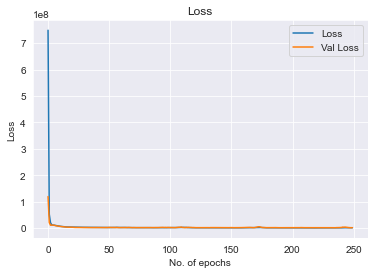

In [11]:
plot_loss(history)

### Get the test split of data

In [12]:
# number of samples from test dataset
test_sample_size = len(X_test)
test_examples, test_targets = list(test_dataset.unbatch().shuffle(batchsize).batch(test_sample_size))[0]

### Sample from the posterior for test predictions

In [13]:
prediction_distribution = prob_bnn_model(test_examples)

# number of samples from posterior
n_samples = 10000

df_predictions = np.zeros((n_samples, test_sample_size))
samples = prediction_distribution.sample(n_samples).numpy()

for idx in range(test_sample_size):
    df_predictions[:, idx]= samples[:,idx,:].flatten()

    
df_predictions = y_test_scaler.inverse_transform(df_predictions)
df = pd.DataFrame(df_predictions, columns=[i for i in range(test_sample_size)])

### A look at the metrics from the test dataset

In [14]:
y_pred = df.mean(axis=0).values
stddev = df.std(axis=0).values

# scale the target data back out
y_true = y_test_scaler.inverse_transform(test_targets.numpy().reshape(-1,1)).flatten()
# y_true = test_targets.numpy()

In [15]:
df_analysis = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'stddev': stddev})
df_analysis['lower'] = np.percentile(df_predictions, 2.5, axis=0)
df_analysis['upper'] = np.percentile(df_predictions, 97.5, axis=0)
df_analysis['percent_uncertain'] = (df_analysis['stddev'] / df_analysis['y_pred']) * 100
df_analysis['difference'] = abs(df_analysis['y_true'] - df_analysis['y_pred'])
df_analysis['percent_difference'] = (abs(df_analysis['y_true'] - df_analysis['y_pred']) /  df_analysis['y_pred']) * 100

# df_analysis.sort_values('y_pred', inplace=True)
df_analysis.reset_index(inplace=True)

### Look at some regression metrics to determine the goodness of fit

In [16]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
pearson = pearsonr(y_true, y_pred)[0]
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'pearson: {pearson}')

R2: 0.8786277712615866
MSE: 615808790.0343636
MAE: 17239.218947074452
pearson: 0.9484628793456386


### Visualize the predictions vs true values

<Figure size 864x648 with 0 Axes>

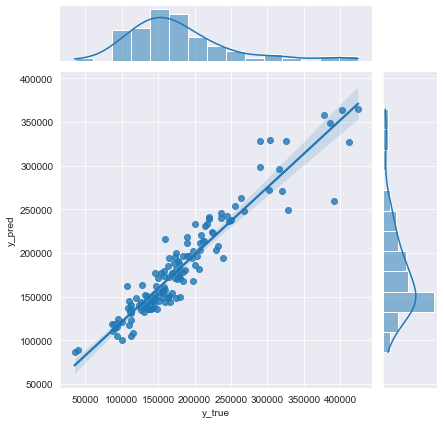

In [17]:
plt.figure(figsize=(12,9))
sns.jointplot(data=df_analysis, x='y_true', y='y_pred', kind='reg')

### Take look at a few examples from the test set and their credible intervals

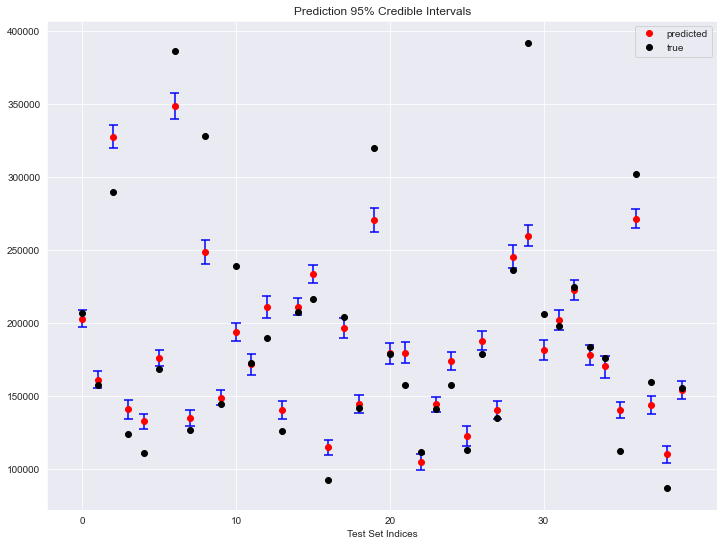

In [18]:
# plot parameters
n_checks = 40
x = np.arange(n_checks)
hline_left = x - .3
hline_right = x + .3

means = df_analysis.loc[:n_checks-1, 'y_pred']
uppers = df_analysis.loc[:n_checks-1, 'upper']
lowers = df_analysis.loc[:n_checks-1, 'lower']
trues = df_analysis.loc[:n_checks-1, 'y_true']

plt.figure(figsize=(12,9))
plt.vlines(x, ymin=lowers, ymax=uppers, color='blue')
plt.hlines(uppers, xmin=hline_left, xmax=hline_right, color='blue')
plt.hlines(lowers, xmin=hline_left, xmax=hline_right, color='blue')
plt.plot(x, means, 'o', color='red', label='predicted')
plt.plot(x, trues, 'o', color='black', label='true')
plt.xticks(range(0, n_checks, 10))
plt.xlabel('Test Set Indices')
plt.title('Prediction 95% Credible Intervals')
plt.legend()

The model is fairly confident in these predictions, but there are a lot of true values outside the credible intervals.

### Let's look at the scatter plot of predicted target values and standard devations.

<Figure size 864x648 with 0 Axes>

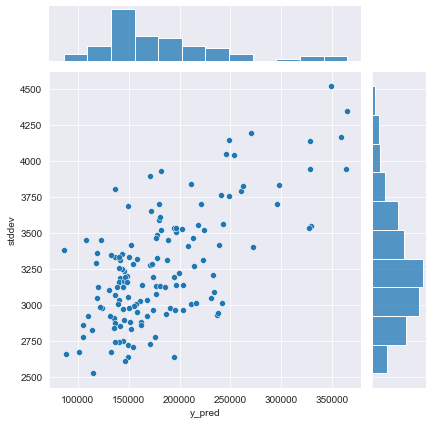

In [19]:
plt.figure(figsize=(12,9))
sns.jointplot(data=df_analysis, x='y_pred', y='stddev', kind='scatter')

Notice the positive correlation. The model is more uncertain about higher house price since there aren't many examples in that range. 

### Histogram of difference and uncertainty as a percent of predictions' values

<AxesSubplot:xlabel='percent_uncertain', ylabel='Count'>

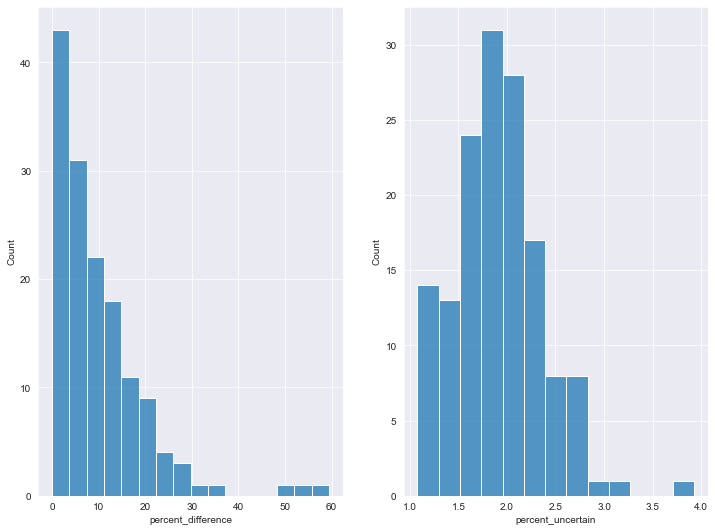

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,9))
sns.histplot(data=df_analysis, x='percent_difference', ax=ax1)
sns.histplot(data=df_analysis, x='percent_uncertain', ax=ax2)

The percent differences are an order of magnitude larger than the percent uncertanties. Perhaps some feature engineering can bring these two quantities in line. 

### Now using the helper function "load_saved_model", load in the saved model from training.

In [21]:
model_loc = 'best-iowa-housing-price-model.h5'
loaded_model = load_saved_model(best_params, model_loc, features, loss)

### Get some new samples

In [22]:
prediction_distribution = loaded_model(test_examples)
n_samples = 10000
df = np.zeros((n_samples, test_sample_size))
samples = prediction_distribution.sample(n_samples).numpy()

for idx in range(test_sample_size):
    df[:, idx]= samples[:,idx,:].flatten()

df = pd.DataFrame(df, columns=[i for i in range(test_sample_size)])
y_pred2 = y_test_scaler.inverse_transform(df.mean(axis=0).values.reshape(-1,1)).flatten()

### See the new predictions' metrics.

In [23]:
mse = mean_squared_error(y_true, y_pred2)
mae = mean_absolute_error(y_true, y_pred2)
r2 = r2_score(y_true, y_pred2)
pearson = pearsonr(y_true, y_pred2)[0]
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'pearson: {pearson}')

R2: 0.8902745572463503
MSE: 556716250.8298285
MAE: 16045.059006835238
pearson: 0.9506153818086533


### This is the same model, but notice the scores are different because our model is stochastic. Hence our samples are not the same samples we generated earlier. 